Atalov S. (TSI AUCA)

DCPT

# Perceptron Implementation

---

**Instructions:**
- Do not use loops (for/while) in your code, unless the instructions explicitly ask you to do so.
- Use `np.dot(X,Y)` to calculate dot products.

**You will learn to:**
- Build the general architecture of a learning algorithm, including:
    - Initializing parameters
    - Calculating the cost function and its gradient
    - Using an optimization algorithm (gradient descent) 
- Gather all three functions above into a main model function, in the right order.

Before importing modules:

`pip install h5py`

In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt

import h5py

from PIL import Image

---
## Part 1. Preparing the dataset

**Problem Statement**: You are given a dataset ("data.h5") containing:
- a training set of m_train images labeled as cat (y=1) or non-cat (y=0)
- a test set of m_test images labeled as cat or non-cat
- each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB). Thus, each image is square (height = num_px) and (width = num_px).

You will build a simple image-recognition algorithm that can correctly classify pictures as cat or non-cat.

In [2]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

y = [1], it's a 'cat' picture.


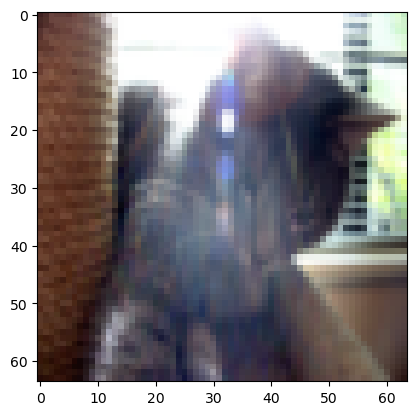

In [6]:
# Example of a picture
index = 42
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

In [8]:
print("Number of training examples:", train_set_x_orig.shape[0])
print("Number of test examples:", test_set_x_orig.shape[0])

num_px = test_set_x_orig.shape[1]
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")

Number of training examples: 209
Number of test examples: 50
Each image is of size: (64, 64, 3)


### Reshaping

Reshape the training and test data sets so that images of size (num_px, num_px, 3) are flattened into single vectors of shape (num\_px $*$ num\_px $*$ 3, 1).

```python
X_flatten = X.reshape(X.shape[0], -1).T      # X.T is the transpose of X
```

In [10]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.

One common preprocessing step in machine learning is to center and standardize your dataset, meaning that you substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array. But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

[Why normalize images by subtracting dataset's image mean, instead of the current image mean in deep learning?](https://stats.stackexchange.com/questions/211436/why-normalize-images-by-subtracting-datasets-image-mean-instead-of-the-current)

In [11]:
train_set_x = train_set_x_flatten / 255.
test_set_x = test_set_x_flatten / 255.

**What you need to remember:**

Common steps for pre-processing a new dataset are:
- Figure out the dimensions and shapes of the problem (m_train, m_test, num_px, ...)
- Reshape the datasets such that each example is now a vector of size (num_px \* num_px \* 3, 1)
- "Standardize" the data

---
## Part 2. Building the Parts of the Algorithm

**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

**Key steps**:
In this exercise, you will carry out the following steps: 
* Initialize the parameters of the model
* Learn the parameters for the model by minimizing the cost  
* Use the learned parameters to make predictions (on the test set)
* Analyse the results and conclude

### 2.1 Sigmoid Function

Implement `sigmoid()`. As you've seen in the figure above, you need to compute $sigmoid(z) = \frac{1}{1 + e^{-z}}$ for $z = w^T x + b$ to make predictions. Use np.exp().

In [51]:
def sigmoid(z):

    s = 1/1+np.exp(-z)

    return s

### 2.2 Initializing parameters

Implement parameter initialization in the cell below. 

1. You have to initialize w as a vector of zeros
2. You have to initialize b as a zero

In [84]:
def initialize(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias) of type float
    """
    w = np.random.rand(dim,1)
    b = 0

    return w, b

### 2.3 Forward Propagation

Forward Propagation:
- You get X
- You compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- You calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}(y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)}))$



In [85]:
def forward(w, b, X, Y):
    
    m = X.shape[1] # number of examples in X

    A = sigmoid(np.dot(w.T,X) + b)
    cost = np.mean(Y*np.log(A)+(1-Y) * np.log(1-A))
    
    cost = np.squeeze(np.array(cost))
    return A, cost

### 2.4 Backward Propagation

Here are the two formulas you will be using: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [86]:
def backward(A, X, Y):
    m = X.shape[1]
    
    dw = (X @ (A - Y).T)/m
    db = np.sum(A - Y)/m
    
    grads = {"dw": dw,
             "db": db}
    return grads

### 2.5 Gradient Descent Optimization

$\theta = \theta - \alpha \frac{\partial J }{ \partial \theta }$

In [91]:
def optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009):
    
    w = copy.deepcopy(w)
    b = copy.deepcopy(b)
    
    costs = []
    
    for i in range(num_iterations):
        
        A, cost = forward(w, b, X, Y)
        grads = backward(A, X, Y)
        
        dw = grads["dw"]
        db = grads["db"]
        
        w = w - learning_rate * dw
        b = b - learning_rate * db

        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
            # Print the cost every 100 training iterations
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

### 2.6 Predict

In [92]:
def predict(w, b, X):
    
    m = X.shape[1]
    
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    A = sigmoid(np.dot(w.T, X) + b)
    
    for i in range(A.shape[1]):

        if A[0, i] > 0.5:
            Y_prediction[0, i] = 1
        else:
            Y_prediction[0, i] = 0

    return Y_prediction

<font color='blue'>
    
**What to remember:**
    
You've implemented several functions that:
- Calculates the sigmoid function
- Initialize (w,b)
- Optimize the loss iteratively to learn parameters (w,b):
    - Computing the cost and its gradient 
    - Updating the parameters using gradient descent
- Use the learned (w,b) to predict the labels for a given set of examples

---
## Part 3. Model

In [95]:
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5):
    
    w, b = initialize(X_train.shape[0])

    params, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate)

    w = params['w']
    b = params['b']

    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    
    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

#### Try to play with the learning rate, number of iterations, and look and the learning curve

In [101]:
perceptron_model = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=3000, learning_rate=0.0005)

C:\Users\akzholtoev_a\AppData\Local\Temp\ipykernel_11512\2919723670.py:6: RuntimeWarning: divide by zero encountered in log
  cost = np.mean(Y*np.log(A)+(1-Y) * np.log(1-A))
C:\Users\akzholtoev_a\AppData\Local\Temp\ipykernel_11512\2919723670.py:6: RuntimeWarning: invalid value encountered in multiply
  cost = np.mean(Y*np.log(A)+(1-Y) * np.log(1-A))


Cost after iteration 0: nan
Cost after iteration 100: nan
Cost after iteration 200: nan
Cost after iteration 300: nan
Cost after iteration 400: nan
Cost after iteration 500: nan
Cost after iteration 600: nan
Cost after iteration 700: nan
Cost after iteration 800: nan
Cost after iteration 900: nan
Cost after iteration 1000: nan
Cost after iteration 1100: nan
Cost after iteration 1200: nan
Cost after iteration 1300: nan
Cost after iteration 1400: nan
Cost after iteration 1500: nan
Cost after iteration 1600: nan
Cost after iteration 1700: nan
Cost after iteration 1800: nan
Cost after iteration 1900: nan
Cost after iteration 2000: nan
Cost after iteration 2100: nan
Cost after iteration 2200: nan
Cost after iteration 2300: nan
Cost after iteration 2400: nan
Cost after iteration 2500: nan
Cost after iteration 2600: nan
Cost after iteration 2700: nan
Cost after iteration 2800: nan
Cost after iteration 2900: nan
train accuracy: 34.44976076555024 %
test accuracy: 66.0 %


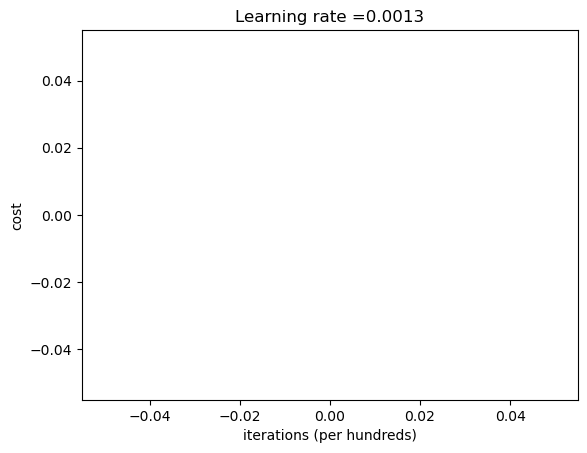

In [74]:
# Plot learning curve (with costs)
costs = np.squeeze(perceptron_model['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(perceptron_model["learning_rate"]))
plt.show()

y = 1, you predicted that it is a "cat" picture.


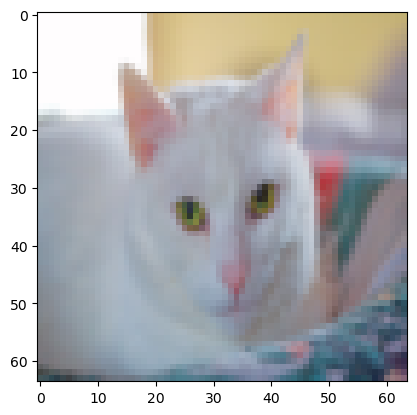

In [75]:
# Example of a pictures
index = 2
plt.imshow(test_set_x[:, index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + classes[int(perceptron_model['Y_prediction_test'][0,index])].decode("utf-8") +  "\" picture.")

---

## Part 4. Test your own picture

In [ ]:
# preprocess the image to fit your algorithm
fname = "cat.jpeg" 
image = np.array(Image.open(fname).resize((num_px, num_px))) # 64 x 64
plt.imshow(image)

# normalizing
image = image / 255.
image = image.reshape((1, num_px * num_px * 3)).T


# making a prediction
my_predicted_image = predict(perceptron_model["w"], perceptron_model["b"], image)

print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")